# Deep Cache with SyntheticDataset

Reference Paper
> Deep Cache: A Deep Learning Based Framework For Content Caching

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/y_dataset1_window.npy
/kaggle/input/syntheticDataset_O50.csv
/kaggle/input/X_dataset1_window.npy


In [2]:
# Use GPU if available, otherwise fall back to CPU
import tensorflow as tf

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(device)

2025-05-29 13:11:18.772391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748524278.959296      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748524279.015289      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/GPU:0


In [3]:
# Load data
df = pd.read_csv('/kaggle/input/syntheticDataset_O50.csv') 
df

,object_ID,request_time
0,5,2.961472
1,25,3.274127
2,2,3.785475
3,2,4.455687
4,4,5.288994
...,...,...
292141,39,304330.451276
292142,39,304352.296649
292143,39,304405.469075
292144,39,304442.964190


## Split Data 
- To align with the paper's goal which is predicting the future characteristics of an object based on past logs, we split the dataset into 60% for training and 40% for evaluation.

In [4]:
cut_idx = int(len(df) * 0.6)
train_df = df.iloc[:cut_idx].reset_index(drop=True)
test_df = df.iloc[cut_idx:].reset_index(drop=True)

## Feature Engineering
> "For dataset 1, the probability of object $o^i$ is calculated as $Ni$ /1000, where $N^i$ represents the number of occurrences of $o^i$ in the window of past 1K objects."
- Using step=1 generated too much data, so we used step=100 to make it manageable.

In [5]:
window_size = 1000
step = 100
m, k = 20, 10 # Sequence length for input(m) and output(k)

X = []
y = []

object_ids = df['object_ID'].unique()
object_ids.sort()
num_objects = len(object_ids) # Number of unique objects: 50

In [6]:
# Generate training data for sequence-to-sequence modeling from object request logs
for i in range(0, len(train_df) - window_size * (m + k), step):
    seq = train_df['object_ID'].iloc[i : i + window_size * (m + k)]
    x_seq, y_seq = [], []
    
    # Build the input sequence: m windows of past requests
    for j in range(m):
        window = seq[j * window_size : (j + 1) * window_size]
        counts = window.value_counts(normalize=True).reindex(object_ids, fill_value=0).values
        x_seq.append(counts)
        
    # Build the output sequence: k windows of future requests
    for j in range(k):
        window = seq[(m + j) * window_size : (m + j + 1) * window_size]
        counts = window.value_counts(normalize=True).reindex(object_ids, fill_value=0).values
        y_seq.append(counts)

    X.append(x_seq) # (#samples, 20, d)
    y.append(y_seq) # (#samples, 26, d)

In [7]:
X = np.array(X)
y = np.array(y)

# Reshape X and y to fit LSTM input requirements:
# X: (samples * num_objects, m, 1)
# y: (samples * num_objects, K, 1)
X = X.transpose(0, 2, 1).reshape(-1, m, 1)  
y = y.transpose(0, 2, 1).reshape(-1, k, 1)  
print("X.shape (reshaped):", X.shape)
print("y.shape (reshaped):", y.shape)

X.shape (reshaped): (72650, 20, 1)
y.shape (reshaped): (72650, 10, 1)


In [8]:
np.save("X_dataset1_window.npy", X)
np.save("y_dataset1_window.npy", y)

## Build LSTM Model
> "For our datasets, we use a two-layer depth LSTM Encoder-Decoder model with 128 and 64 as the number of hidden units. ... The loss function is chosen as mean-squared-error (MSE)."

In [9]:
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model

In [10]:
def build_seq2seq_model(m, k):
    # ----- Encoder -----
    encoder_inputs = Input(shape=(m, 1))  # Input shape: (sequence_length, 1)

    # Two-layer encoder with 128 and 64 hidden units
    encoder_lstm_1 = LSTM(128, return_sequences=True)
    encoder_lstm_2 = LSTM(64, return_state=True)

    x = encoder_lstm_1(encoder_inputs)
    encoder_outputs, state_h, state_c = encoder_lstm_2(x)
    encoder_states = [state_h, state_c]  # Final encoder states passed to decoder

    # ----- Decoder -----
    decoder_inputs = RepeatVector(k)(encoder_outputs)  # Repeat context vector for k time steps

    # Two-layer decoder with 128 and 64 hidden units
    decoder_lstm_1 = LSTM(128, return_sequences=True)
    decoder_lstm_2 = LSTM(64, return_sequences=True)

    x = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = decoder_lstm_2(x)

    # Predict one value per time step
    decoder_dense = TimeDistributed(Dense(1))
    output_seq = decoder_dense(decoder_outputs)

    # Compile the model with MSE loss and MAE metric
    model = Model(encoder_inputs, output_seq)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

## Train Model
> "We ran our experiments for a number of epochs equal to 30, with the batch size set to 10% of the training data."

In [11]:
batch_size = int(len(X) * 0.1)
print("Batch size:", batch_size)

model = build_seq2seq_model(m, k)
model.fit(X, y, epochs=30, batch_size=batch_size)

# Predict
y_pred = model.predict(X)  

print("Prediction Shape:", y_pred.shape)

Batch size: 7265


I0000 00:00:1748524310.793615      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30


I0000 00:00:1748524318.030681      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 0.0011 - mae: 0.0226
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 7.3760e-04 - mae: 0.0168
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 5.7157e-04 - mae: 0.0140
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 4.5512e-04 - mae: 0.0111
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 3.9016e-04 - mae: 0.0101
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 3.5157e-04 - mae: 0.0093
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 3.2402e-04 - mae: 0.0088
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 2.9397e-04 - mae: 0.0085
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 2.7294e-04 - mae: 0.0083
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 2.7122e-04 - mae: 0.0083
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 2.6617e-04 - mae: 0.0081
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 2.5849e-04 - mae:

## Cache Policy Setting
Foreveryobjectrequestoit attimet,wegenerateavaryingnumber of “fake object requests” (denoted as Ft ). For dataset 1, we generate Ft by calculating the top M = 5 objects with highest probability at t + 1. 

In [12]:
M = 5
top_objects_each_t = []
for i in range(len(y_pred)):
    next_probs = y_pred[i, 0].flatten()
    top_indices = next_probs.argsort()[-M:][::-1]
    top_objects_each_t.append(list(top_indices))

## Integral Operator
> "The operator is a simple merge operator, where the actual object request is followed by all the fake requests generated by our Caching Policy. This helps us to update the state of the cache by prefetching objects based on future object popularity and evict unpopular ones."

In [13]:
# Merge real requests and fake requests
merged_requests = []
fake_insert_idx = 0
insert_interval = 5

actual_requests = test_df.sort_values('request_time')['object_ID'].tolist()

for t, req in enumerate(actual_requests):
    merged_requests.append(req)
    if fake_insert_idx < len(top_objects_each_t) and t % insert_interval == 0:
        fake_objs = top_objects_each_t[fake_insert_idx]
        merged_requests.extend(fake_objs)
        fake_insert_idx += 1

In [14]:
# LRU Cache simulator
from collections import OrderedDict

class LRUCache:
  def __init__(self, capacity):
    self.capacity = capacity
    self.cache = OrderedDict()
    self.hit = 0
    self.miss = 0

  def request(self, obj_id):
    if obj_id in self.cache:
        self.cache.move_to_end(obj_id)
        self.hit += 1
        return 1
    else:
        self.miss += 1
        if len(self.cache) >= self.capacity:
            self.cache.popitem(last=False) 
        self.cache[obj_id] = True
        return 0

  def get_hit_ratio(self):
    total = self.hit + self.miss
    return self.hit / total if total > 0 else 0

## Deep Cache vs Traditional LRU
> "We compare traditional LRU with Deep Cache, and without Deep Cache."
> "For dataset 1, we set the cache size to 5."
- When the cache size is small (cache size = 5), incorrect prefetching by DeepCache leads to cache pollution, evicting useful objects and resulting in a lower hit ratio compared to traditional LRU.
- However, as the cache size increases, the impact of incorrect predictions diminishes and the benefit of correctly prefetched objects increases, allowing DeepCache to outperform traditional LRU.


Max difference at cache size 6:
DeepCache hit ratio: 0.4561
Traditional LRU hit ratio: 0.3935


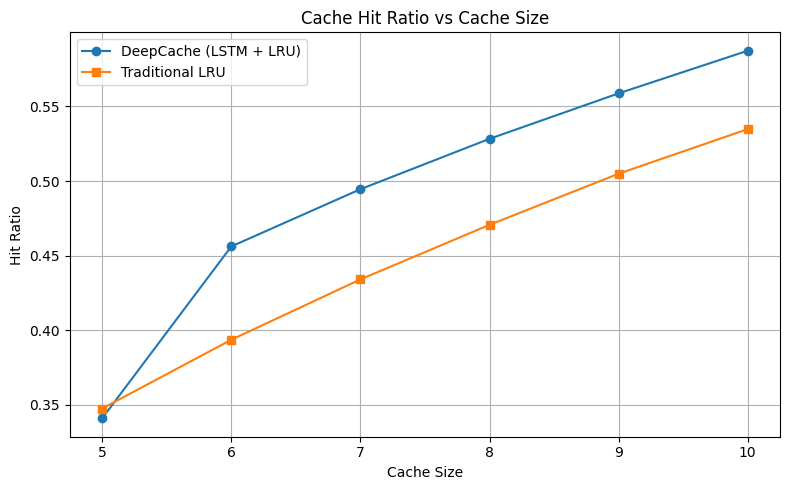

In [15]:
import matplotlib.pyplot as plt

deep_hit_ratios = []
trad_hit_ratios = []
cache_sizes = list(range(5, 11))  # 5 to 10

for cache_size in cache_sizes:
    # Execute LRU with Deep Cache (on merged requests)
    lru_deep = LRUCache(cache_size)
    hits_deep = []
    for obj_id in merged_requests:
        hit = lru_deep.request(obj_id)
        hits_deep.append(hit)
    deep_hit_ratios.append(round(lru_deep.get_hit_ratio(), 4))

    # Execute traditional LRU (on raw requests)
    lru_traditional = LRUCache(cache_size)
    hits_trad = []
    for obj_id in actual_requests:
        hit = lru_traditional.request(obj_id)
        hits_trad.append(hit)
    trad_hit_ratios.append(round(lru_traditional.get_hit_ratio(), 4))

# Calculate the absolute differences between DeepCache and Traditional LRU hit ratios
diffs = [abs(d - t) for d, t in zip(deep_hit_ratios, trad_hit_ratios)]
max_diff_idx = diffs.index(max(diffs)) # Find the index where the difference is the largest

deep_best_hit_ratio = deep_hit_ratios[max_diff_idx]
lru_best_hit_ratio = trad_hit_ratios[max_diff_idx]

print(f"Max difference at cache size {cache_sizes[max_diff_idx]}:")
print(f"DeepCache hit ratio: {deep_best_hit_ratio}")
print(f"Traditional LRU hit ratio: {lru_best_hit_ratio}")


# Visualize the result
plt.figure(figsize=(8, 5))
plt.plot(cache_sizes, deep_hit_ratios, marker='o', label='DeepCache (LSTM + LRU)')
plt.plot(cache_sizes, trad_hit_ratios, marker='s', label='Traditional LRU')
plt.xlabel('Cache Size')
plt.ylabel('Hit Ratio')
plt.title('Cache Hit Ratio vs Cache Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualize the result

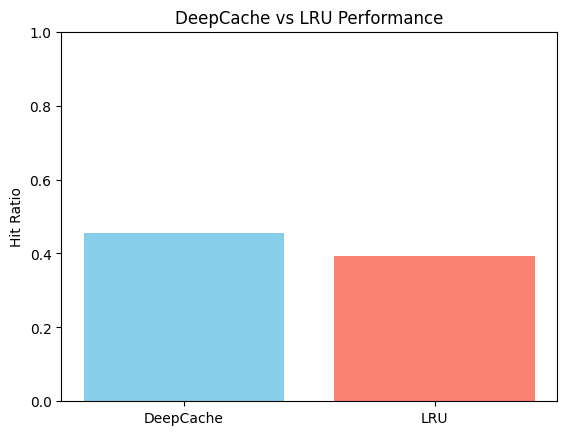

In [16]:
import matplotlib.pyplot as plt

ratios = [
    deep_best_hit_ratio,
    lru_best_hit_ratio
]
labels = ['DeepCache', 'LRU']

plt.bar(labels, ratios, color=['skyblue', 'salmon'])
plt.ylabel('Hit Ratio')
plt.title('DeepCache vs LRU Performance')
plt.ylim(0, 1)
plt.show()

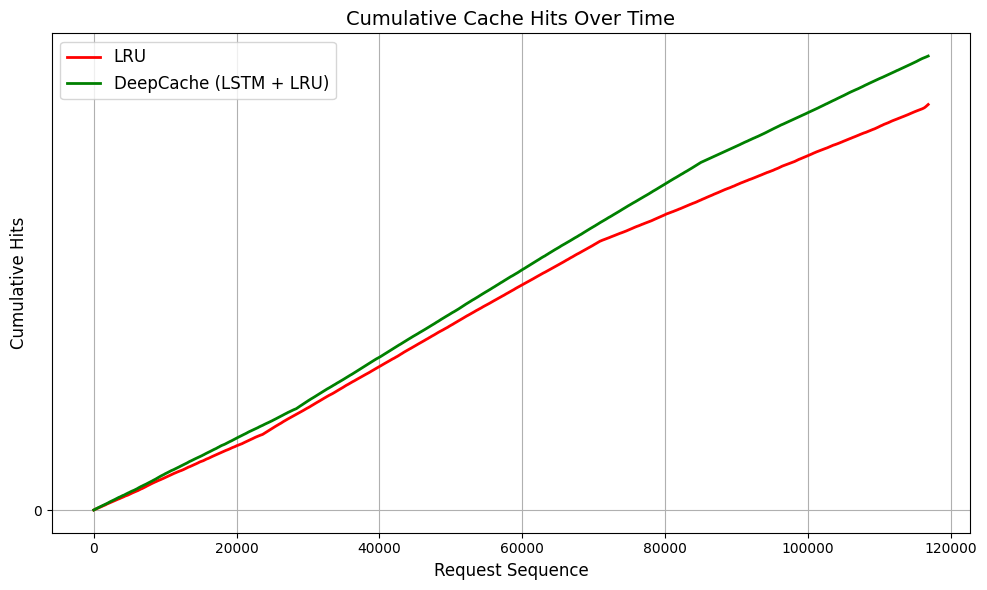

In [17]:
hits_deep = np.array(hits_deep, dtype=int)
hits_trad = np.array(hits_trad, dtype=int)

min_len = min(len(hits_trad), len(hits_deep))

hits_trad = hits_trad[:min_len]
hits_deep = hits_deep[:min_len]
x = np.arange(1, min_len + 1)

x = np.arange(1, len(hits_trad) + 1)
cumulative_deep = np.cumsum(hits_deep)
cumulative_trad = np.cumsum(hits_trad)

step = 10
x = np.arange(1, min_len + 1)[::step]
cumulative_trad = cumulative_trad[::step]
cumulative_deep = cumulative_deep[::step]

y_max = max(cumulative_deep.max(), cumulative_trad.max())
yticks = np.arange(0, y_max + 1, 80000) 

plt.figure(figsize=(10, 6))
plt.plot(x, cumulative_trad, label='LRU', color='red', linewidth=2)
plt.plot(x, cumulative_deep, label='DeepCache (LSTM + LRU)', color='green', linewidth=2)
plt.xlabel('Request Sequence', fontsize=12)
plt.ylabel('Cumulative Hits', fontsize=12)
plt.title('Cumulative Cache Hits Over Time', fontsize=14)
plt.yticks(yticks, fontsize=10)  
plt.xticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()